In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from astropy.io import fits
import scipy.fftpack

In [2]:
from dataHandler.dataset import MHDProjDataset, LogNormalTransform

In [3]:
SOURCE_FOLDER='/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/'
TARGET_FOLDER='/mnt/home/dheurtel/ceph/00_exploration_data/density'
PROJ_AXIS=0 

In [3]:
os.mkdir(os.path.join(TARGET_FOLDER,'b_proj'))

FileExistsError: [Errno 17] File exists: '/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj'

In [4]:
os.mkdir(os.path.join(TARGET_FOLDER,'orth_b_proj'))

FileExistsError: [Errno 17] File exists: '/mnt/home/dheurtel/ceph/00_exploration_data/density/orth_b_proj'

In [9]:
os.listdir(TARGET_FOLDER)

['b_proj', 'orth_b_proj']

In [11]:
def walker(prefix,folder):
    res_path_list=[]
    walker=os.walk(folder)
    for path, _ , files in walker:
        for name in files:
            if name.startswith(prefix):
                res_path_list.append(os.path.join(path,name))
    res_path_list.sort()
    return res_path_list


In [12]:
def fits_to_np(filepath):
    fits_obj=fits.open(filepath)
    np_data=fits_obj[0].data
    return np_data

In [13]:
def path_list_to_np_list(path_list):
    return [fits_to_np(path) for path in path_list]

In [14]:
def np_to_npy(np_list,folder,prefix=None,file_name_list=None):
    if not(prefix==None):
        count=0
        for arr in np_list:
            np.save(os.path.join(folder,prefix+'_'+str(count).zfill(2)),arr)
            count+=1
    elif not(file_name_list==None):
        if len(np_list)==len(file_name_list):
            for i in range(len(np_list)):
                np.save(os.path.join(folder,file_name_list[i]),np_list[i])
        else:
            raise ValueError('Size of list of filenames not the same as size of list of np arrays to save')
    else:
        raise ValueError('Provide a way to name the files')
    

In [15]:
def parrallel_projection(np_list,axis=0):
    return [np.sum(arr, axis=axis) for arr in np_list]

In [16]:
def perpendicular_projections(np_list,axis_exclude=0):
    dims=list(range(np_list[0].ndim)).pop(axis_exclude)
    all_proj=[]
    for dim in dims:
        all_proj+=parrallel_projection(np_list,axis=dim)
    return all_proj

In [19]:
def efficient_walker(prefix,source_folder=SOURCE_FOLDER,target_folder=TARGET_FOLDER,_axis=0,n_dim=3):
    walker=os.walk(source_folder)
    dims=list(range(n_dim))
    dims.pop(_axis)
    count_fits=0
    count_parr=0
    count_orth=0
    for path, _ , files in walker:
        for name in files:
            if name.startswith(prefix):
                count_fits+=1
                np_data=fits.open(os.path.join(path,name))[0].data
                np_main_proj=np.sum(np_data,axis=_axis)
                np.save(os.path.join(target_folder,'b_proj',name),np_main_proj)
                count_parr+=1
                for d in dims:
                    np_other_proj=np.sum(np_data,axis=d)
                    np.save(os.path.join(target_folder,'orth_b_proj',name+str(d)),np_other_proj)
                    count_orth+=1
    print('Explored source folder %s  for prefix %s \n Found %s files \n Saved %s projections of these files along axis %s and %s orthogonal to it \n Everything is saved in folder %s.'%(source_folder,prefix,count_fits,count_parr,_axis,count_orth,target_folder))


In [20]:
efficient_walker('dens')

Explored source folder /mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/  for prefix dens 
 Found 991 files 
 Saved 991 projections of these files along axis 0 and 1982 orthogonal to it 
 Everything is saved in folder /mnt/home/dheurtel/ceph/00_exploration_data/density.


**Examples & Pictures**

In [39]:
w=walker('dens',SOURCE_FOLDER)
head_np_list=[]
for i in range(10):
    head_np_list.append(fits_to_np(w[i]))
    print(w[i])

/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1000/dens_t1000.fits.gz
/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1005/dens_t1005.fits.gz
/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1010/dens_t1010.fits.gz
/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1015/dens_t1015.fits.gz
/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1020/dens_t1020.fits.gz
/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1025/dens_t1025.fits.gz
/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1030/dens_t1030.fits.gz
/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1035/dens_t1035.fits.gz
/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1040/dens_t1040.fits.gz
/mnt/home/bburkhart/ceph/www_data/CATS/MHD/machine_learning/b.1p.1/s1045/dens_t1045.fits.gz


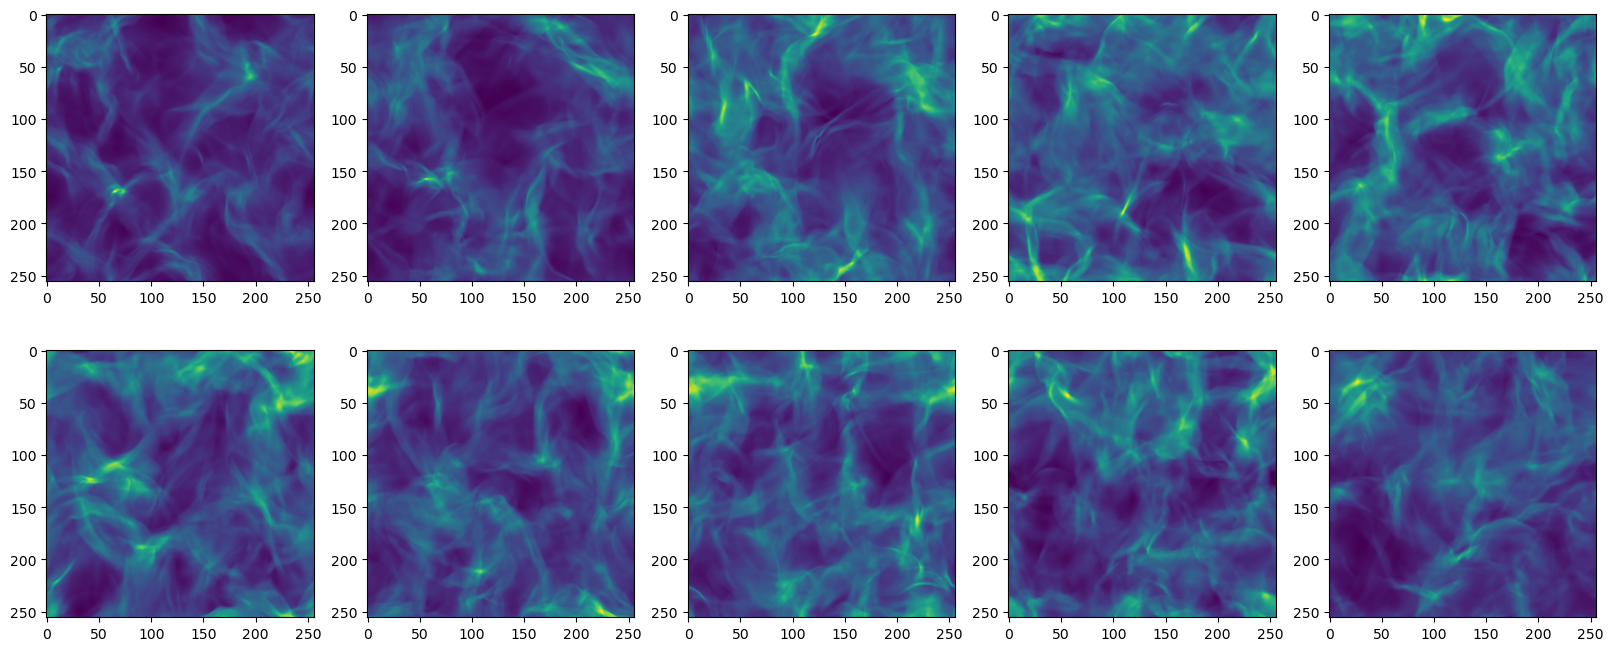

In [54]:
fig, ax =plt.subplots(2,5,figsize=(20, 8))

for i in range(10):
    ax[i//5,i%5].imshow(np.sum(head_np_list[i],axis=0))


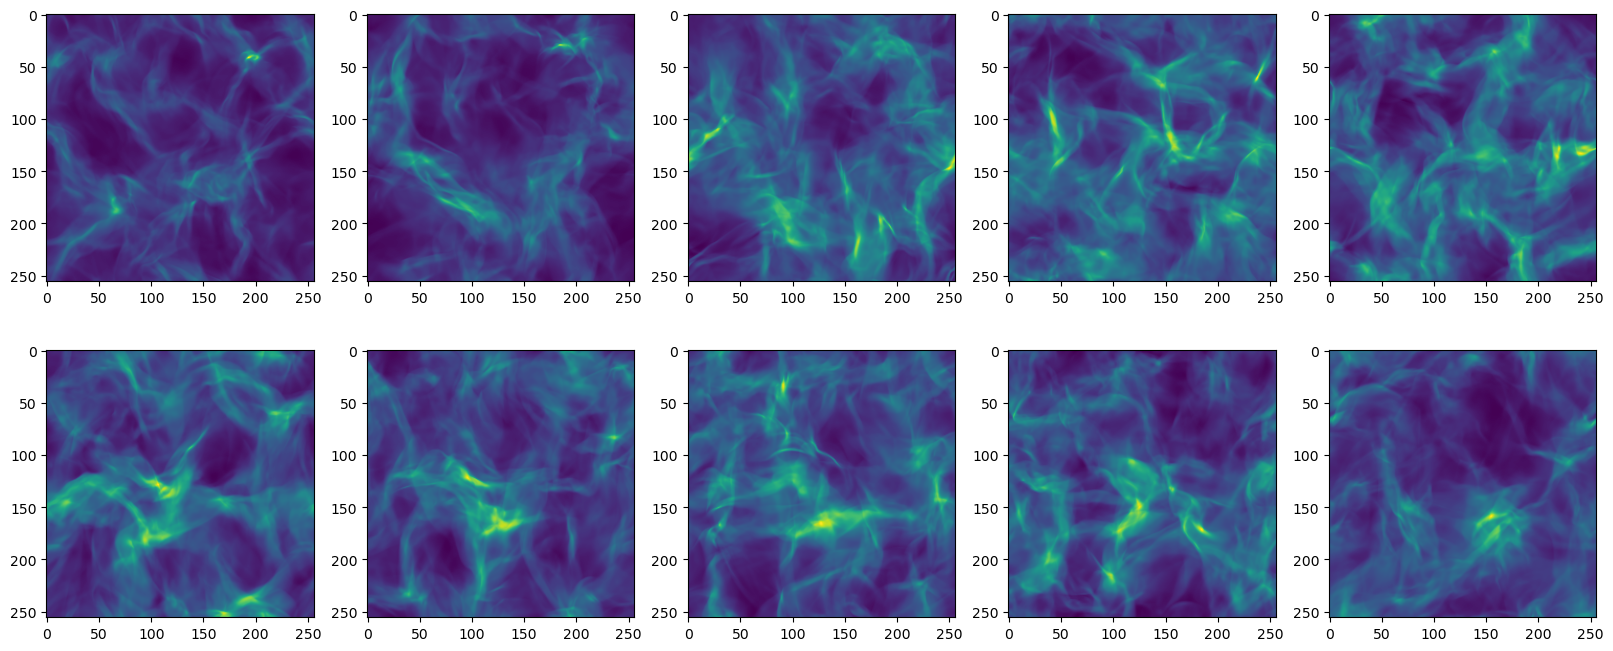

In [55]:
fig, ax =plt.subplots(2,5,figsize=(20, 8))

for i in range(10):
    ax[i//5,i%5].imshow(np.sum(np.fft.fftshift(head_np_list[i]),axis=0))

*As we can see, we have periodic boundary conditions on all three dimensions*

##### TOY DATASET

In [ ]:
TOY_DATASET_DIR='/mnt/home/dheurtel/ceph/00_exploration_data/toy'

In [ ]:
os.mkdir(TOY_DATASET_DIR)

In [ ]:
mu,sigma=5.5,0.3

In [ ]:
t=np.zeros((256,256))
for n in range(1000):
    centerx,centery=np.random.normal(128,30,2)
    radius=np.random.normal(60,5)
    for i in range(256):
        for j in range(256):
            t[i,j]=2.0 if ((i-centery)**2+(j-centerx)**2<=radius**2) else 1.0
    mode=np.random.randint(0,2)*2-1
    t*=mode*np.random.normal(1,0.3)
    t=t*sigma+mu
    t=np.exp(t)
    t=t.astype(np.float32)
    np.save(os.path.join(TOY_DATASET_DIR,'file_'+str(n).zfill(4)),t)


In [ ]:
l=(os.listdir(TOY_DATASET_DIR))
tot=np.concatenate([np.load(os.path.join(TOY_DATASET_DIR,l[i])).reshape(1,1,256,256) for i in range(1000)])
pix=tot.flatten()
pix=(np.log(pix)-mu)/sigma

In [ ]:
plt.hist(pix,density=True, histtype='step', bins=50)
plt.show()

In [ ]:
plt.imshow(tot[11,0],vmin=-2,vmax=2)

**PLANCK NOISE**

Separate real and imaginary part into a tensor of size (2, 256, 256) then normalize by mean (0) and standard deviation ($\approx$ 5e-5)

**Gaussian Field**

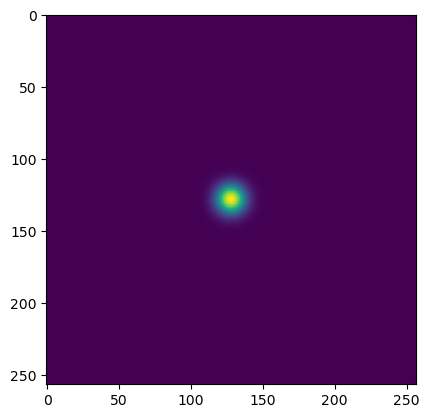

In [4]:
corr=np.zeros((257,257))
for i in range(257):
    for j in range(257):
        corr[i,j]=np.exp(-((i-128)**2+(j-128)**2)/100)
plt.imshow(corr)

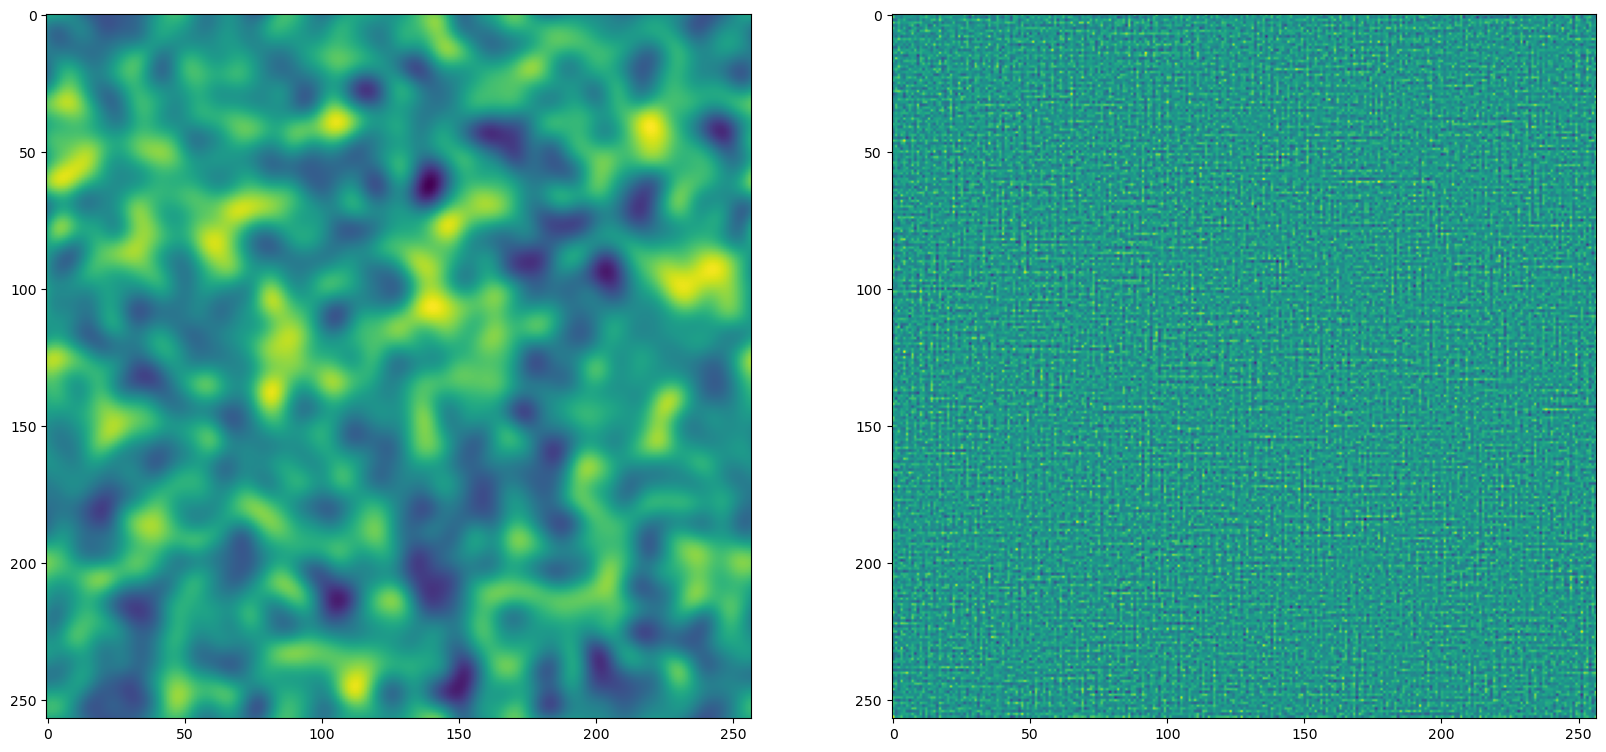

In [5]:
seed=np.random.randn(257,257)
gp=np.fft.ifft2(np.sqrt((np.fft.fft2(np.fft.fftshift(corr))))*np.fft.fft2(seed))
fig, ax =plt.subplots(1,2,figsize=(20, 10))

ax[0].imshow(np.real(gp))
ax[1].imshow(np.imag(gp))

The imaginary part is 7 order of magnitude smaller than the real part. This comes from numerical errors and justifies taking the real part in most of our code blocks 

In [6]:
def fftind(size):
    """ Returns a np array of shifted Fourier coordinates k_x k_y.     
        Input args:
            size (integer): The size of the coordinate array to create
        Returns:
            k_ind, np array of shape (2, size, size) with:
                k_ind[0,:,:]:  k_x components
                k_ind[1,:,:]:  k_y components
        """
    k_ind = np.mgrid[:size, :size] - int( (size + 1)/2 )
    k_ind = scipy.fftpack.fftshift(k_ind)
    return( k_ind )



def gaussian_random_field(alpha = 3.0,
                          size = 256, 
                          flag_normalize = True):
    """ Returns a np array of shifted Fourier coordinates k_x k_y. 
        Input args:
            alpha (double, default = 3.0): 
                The power of the power-law momentum distribution
            size (integer, default = 128):
                The size of the square output Gaussian Random Fields
            flag_normalize (boolean, default = True):
                Normalizes the Gaussian Field:
                    - to have an average of 0.0
                    - to have a standard deviation of 1.0
        Returns:
            gfield (np array of shape (size, size)):
                The random gaussian random field      
        Example:
        import matplotlib
        import matplotlib.pyplot as plt
        example = gaussian_random_field()
        plt.imshow(example)
        """
        
        # Defines momentum indices
    k_idx = fftind(size)

        # Defines the amplitude as a power law 1/|k|^(alpha/2)
    amplitude = np.power( k_idx[0]**2 + k_idx[1]**2 + 1e-10, -alpha/4.0 )
    amplitude[0,0] = 0
    
        # Draws a complex gaussian random noise with normal
        # (circular) distribution
    noise = np.random.normal(size = (size, size)) \
        + 1j * np.random.normal(size = (size, size))
    
        # To real space
    gfield = np.fft.ifft2(noise * amplitude).imag
    
        # Sets the standard deviation to one
    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = gfield/np.std(gfield)
        
    return gfield

In [7]:
g=gaussian_random_field(4)

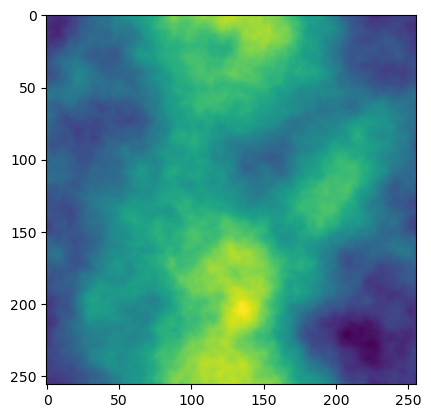

In [8]:
plt.imshow(g)

In [9]:
import numpy as np
import scipy.stats as stats


def compute_autocovariance(data):
    """
    Compute the autocovariance matrix of the input data.
    
    Works for any dimension.

    Parameters
    ----------
    data : array
        Input data.

    Returns
    -------
    array
        Autocovariance matrix.

    """
    return np.real(np.fft.ifftn(np.absolute(np.fft.fftn(data - data.mean())) ** 2) / np.prod(data.shape))

def generate_grf(cov, mean=0.0):
    """
    Generate a realization of a 2D real-valued GRF with periodic boundary conditions
    for a given mean and autocovariance matrix.

    Parameters
    ----------
    cov : array
        2D autocovariance matrix.
    mean : float, optional
        Mean value of the GRF. The default is 0.0.

    Raises
    ------
    Exception
        DESCRIPTION.

    Returns
    -------
    array
        Realization of the corresponding GRF.

    """
    if cov.ndim != 2:
        raise Exception("This function expects cov to be be a 2D array.")
    M, N = cov.shape
    gamma = np.fft.fft2(cov)
    Z = np.random.randn(M, N) + 1j * np.random.randn(M, N)
    X = np.fft.fft2(np.multiply(np.sqrt(gamma), Z / np.sqrt(M * N))).real
    return X + mean

In [10]:
SOURCE_DIR='/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj/'

In [11]:
dataset=MHDProjDataset(SOURCE_DIR,test_batch_length=0,random_rotate=True,transforms=LogNormalTransform())

In [12]:
cov_mean=np.zeros((256,256))

In [13]:
n=len(dataset)
n

991

In [21]:
for data_point in dataset:
    cov_mean+=compute_autocovariance(data_point)/n

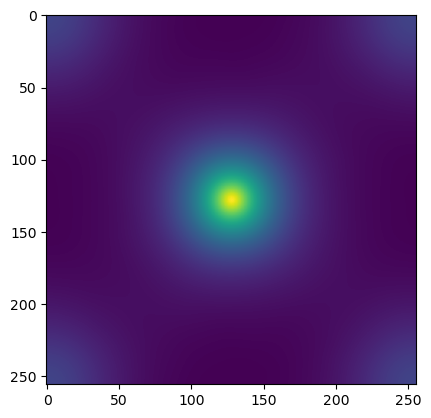

In [22]:
plt.imshow(np.fft.fftshift(cov_mean))

In [23]:
im=generate_grf(cov_mean)

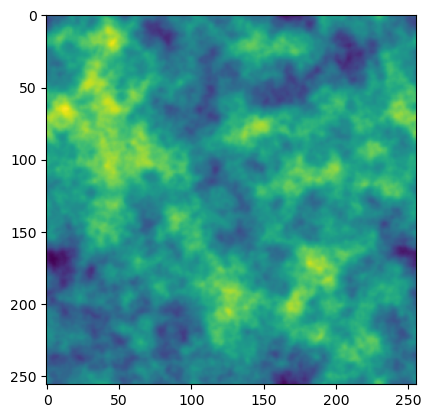

In [24]:
plt.imshow(im)

In [18]:
grf_test=[generate_grf(cov_mean) for i in range(1000)]

In [19]:
cov_mean_test=np.zeros((256,256))
for data_point in grf_test:
    cov_mean_test+=compute_autocovariance(data_point)/1000

In [20]:
np.linalg.norm(cov_mean_test-cov_mean)/np.linalg.norm(cov_mean)

0.030695085497971578

### For our gaussian random field ddpm

In [27]:
power_spectrum = np.fft.fft2(cov_mean).real

In [32]:
POWER_SPECTRUM_FILE = '/mnt/home/dheurtel/ceph/00_exploration_data/power_spectra/same.npy'

In [33]:
np.save(POWER_SPECTRUM_FILE, power_spectrum)

In [48]:
from validationMetrics.powerSpectrum import power_spectrum_iso, plot_ps

In [49]:
bins = np.linspace(0, np.pi, 100)

In [50]:
a,b,c=power_spectrum_iso(im, bins=bins)

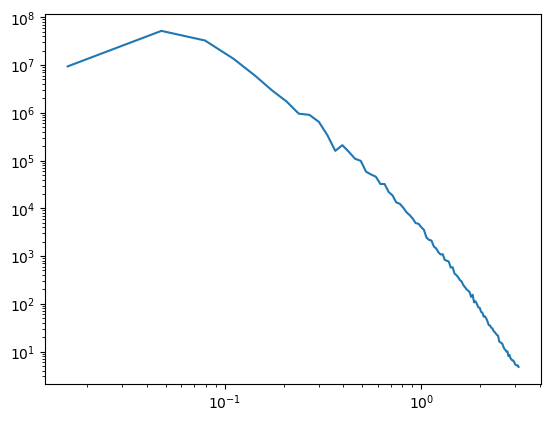

In [51]:
plot_ps(a, [b], show=True)

In [52]:
GRF_DATASET_DIR='/mnt/home/dheurtel/ceph/00_exploration_data/grf'

SUBDIR1='same'
SUBDIR2='power2'

In [53]:
os.mkdir(GRF_DATASET_DIR)

FileExistsError: [Errno 17] File exists: '/mnt/home/dheurtel/ceph/00_exploration_data/grf'

In [54]:
os.mkdir(os.path.join(GRF_DATASET_DIR, SUBDIR1))
os.mkdir(os.path.join(GRF_DATASET_DIR, SUBDIR2))

FileExistsError: [Errno 17] File exists: '/mnt/home/dheurtel/ceph/00_exploration_data/grf/same'

In [55]:
for n in range(1024):
    t = generate_grf(cov_mean)
    t=t.astype(np.float32)
    np.save(os.path.join(GRF_DATASET_DIR,SUBDIR1,'file_'+str(n).zfill(4)),t)

In [65]:
for n in range(1024):
    t = gaussian_random_field(4)
    t=t.astype(np.float32)
    np.save(os.path.join(GRF_DATASET_DIR,SUBDIR2,'file_'+str(n).zfill(4)),t)

In [8]:
dataset_same=MHDProjDataset(os.path.join(GRF_DATASET_DIR, SUBDIR2), None, random_rotate=True,test_batch_length=128)

In [12]:
power_spectra1=np.concatenate([power_spectrum_iso(data_point,bins=bins)[1].reshape(1,100) for data_point in dataset_same],axis=0)

Text(0.5, 0.01, 'Wavenumber')

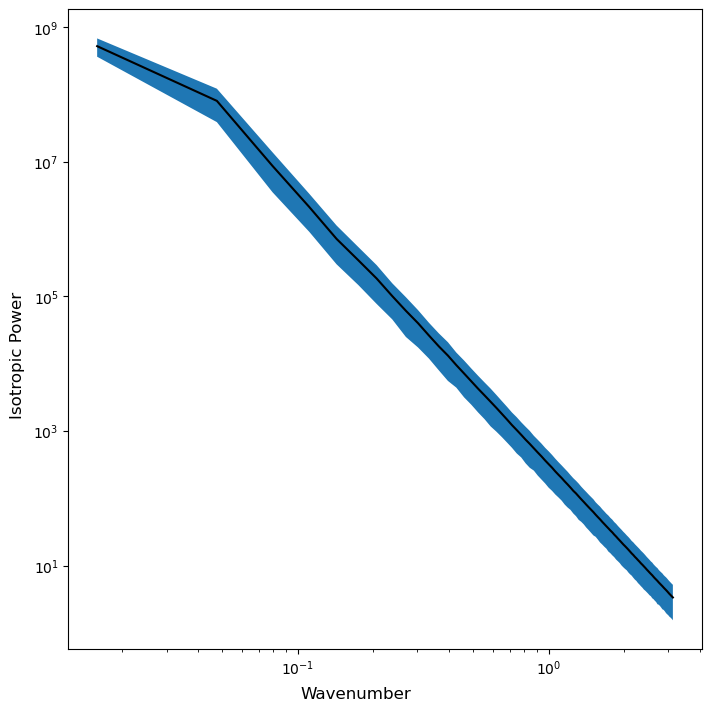

In [13]:
bins_centers = (bins[:-1] + bins[1:])/2
    
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')
mean1,std1=np.mean(power_spectra1,axis=0)[:99],np.std(power_spectra1,axis=0)[:99]

ax.plot(bins_centers,mean1,'-k')
ax.fill_between(bins_centers,mean1+std1,mean1-std1)

ax.set_xscale('log')
ax.set_yscale('log')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')



In [32]:
SUBDIR3='gauss'

In [56]:
os.mkdir(os.path.join(GRF_DATASET_DIR, SUBDIR3))

In [57]:
for n in range(1024):
    t = np.random.randn(256,256)
    t=t.astype(np.float32)
    np.save(os.path.join(GRF_DATASET_DIR,SUBDIR3,'file_'+str(n).zfill(4)),t)

**Tools for physical transformations**

In [12]:
def QiU_to_EiB(data):
    """Convert Q+iU maps to E+iB maps.
    cf Kamionkowski, Kovetz 2015

    Parameters
    ----------
    data : array_like
        Q+iU maps. The two last dimensions are the spatial dimensions.

    Returns
    -------
    array_like
        E+iB maps. The two last dimensions are the spatial dimensions.
    """
    M, N = data.shape[-2:]

    k2d_x, k2d_y = np.meshgrid(np.fft.fftfreq(M), np.fft.fftfreq(N), indexing='ij')
    phik = np.arctan2(k2d_y, k2d_x)

    data_QiUf = np.fft.fft2(data)

    return np.fft.ifft2(np.exp(-2j*phik)*data_QiUf) / np.sqrt(2)

def EiB_to_QiU(data):
    """Convert E+iB maps to Q+iU maps.
    cf Kamionkowski, Kovetz 2015

    Parameters
    ----------
    data : array_like
        E+iB maps. The two last dimensions are the spatial dimensions.

    Returns
    -------
    array_like
        Q+iU maps. The two last dimensions are the spatial dimensions.
    """
    M, N = data.shape[-2:]

    k2d_x, k2d_y = np.meshgrid(np.fft.fftfreq(M), np.fft.fftfreq(N), indexing='ij')

    phik = np.arctan2(k2d_y, k2d_x)

    data_Eibf = np.fft.fft2(data)

    return np.fft.ifft2(np.exp(2j*phik)*data_Eibf * np.sqrt(2))

# Constants
h = 6.62607015e-34  # in J.s
c = 299792458       # in m/s
k = 1.380649e-23    # in J/K

def planck_function(nu, T):
    return (2*h*nu**3 / c**2) * 1 / (np.exp(h*nu/(k*T)) - 1)

def mbb_emission(nu, T, beta, nu_0=353e9):
    return (nu/nu_0)**beta * planck_function(nu, T)

def build_Stokes(n, bx, by, bz, channels, proj="x", p0=0.1, T_vals=(15., 1.), beta_vals=(1.5, 0.2)):
    """_summary_

    Input cubes axes order must be [Z, Y, X].

    Parameters
    ----------
    n : _type_
        _description_
    bx : _type_
        _description_
    by : _type_
        _description_
    bz : _type_
        _description_
    channels : _type_
        In Hz.
    proj : str, optional
        _description_, by default "x"
    p0 : float, optional
        _description_, by default 0.1
    T_vals : tuple, optional
        Temperature mean and std, in K, by default (15., 1.)
    beta_vals : tuple, optional
        Spectral index mean and std, in, by default (1.5, 0.2)

    Returns
    -------
    _type_
        _description_

    Raises
    ------
    NotImplementedError
        _description_
    """
    N = n.shape[0]
    assert n.shape == (N, N, N) # Cubic box is assumed

    # Temperatures (K) and spectral indices for model
    T_mean = T_vals[0]
    T_std = T_vals[1]
    b_mean = beta_vals[0]
    b_std = beta_vals[1]

    # Model for temperature and spectral indices maps
    n_norm_ranks = stats.rankdata(n) / (1 + N**3)
    T_map = stats.norm.ppf(1 - n_norm_ranks, loc=T_mean, scale=T_std).reshape((N, N, N))
    b_map = stats.norm.ppf(n_norm_ranks, loc=b_mean, scale=b_std).reshape((N, N, N))

    # Magnetic part
    b_norm2 = (bx ** 2 + by ** 2 + bz ** 2)
    if proj == "x":
        projaxis = 2
        I_mag_part = (by**2 + bz**2) / b_norm2 - 2/3
        QiU_mag_part = (by + 1j * bz) ** 2 / b_norm2
    elif proj == "z":
        projaxis = 0
        I_mag_part = (bx**2 + by**2) / b_norm2 - 2/3
        QiU_mag_part = (bx + 1j * by) ** 2 / b_norm2
    else:
        raise NotImplementedError(f"proj={proj} invalid!")

    I_maps = np.zeros((len(channels), N, N), dtype=np.float32)
    QiU_maps = np.zeros((len(channels), N, N), dtype=np.complex64)

    # Projection
    for i, chan in enumerate(channels):
        # MBB map
        mbb = mbb_emission(chan, T_map, b_map, nu_0=353e9)

        I_maps[i] = np.mean(mbb * n * (1 - p0*I_mag_part), axis=projaxis)
        QiU_maps[i] = np.mean(mbb * n * QiU_mag_part, axis=projaxis)
    
    return I_maps, QiU_maps